In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
import re
from matplotlib import pyplot as plt
from transformers import BertTokenizer

In [3]:
train_df = pd.read_excel("../Scrapper_New/Data_Files/Final/CrimevsNonCrime.xlsx")
print(train_df.describe())
print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")

                                                    Title  Label
count                                               16864  16864
unique                                              16330      2
top     FIFA takes on EA Sports video game in soccer’s...  Crime
freq                                                    4   8641
All entries unique: False


In [4]:
train_df.drop_duplicates(subset=['Title'], inplace=True, ignore_index=True, keep='first')
print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")

All entries unique: True


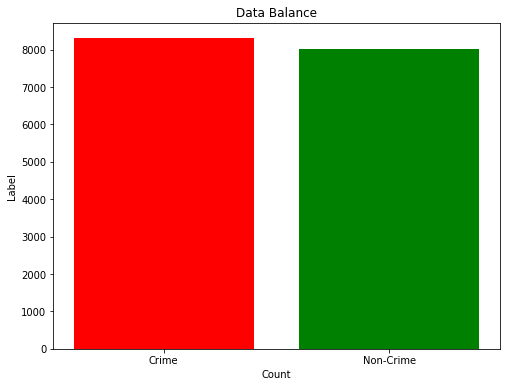

In [7]:
filtered_df = pd.DataFrame(columns=['text', 'label', 'word_count'])
filtered_df['label'] = list((pd.Categorical(train_df['Label']).codes).astype(int))
label_counts = train_df['Label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Data Balance')
plt.show()

Average Word count: 12.005939987752603


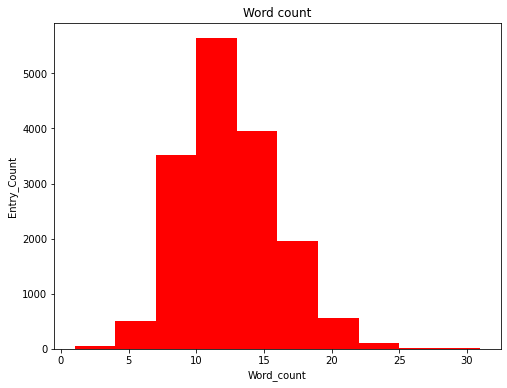

In [9]:
text_list = []
word_count = []

for entry in train_df['Title']:
    new_text = re.sub("[^a-zA-Z ]", " ", entry)
    new_text = new_text.lower().split()
    word_count.append(len(new_text))
    new_text = ' '.join(new_text)
    text_list.append(new_text)

filtered_df['text'] = text_list
filtered_df['word_count'] = word_count

plt.figure(figsize=(8, 6))
print(f'Average Word count: {np.average(word_count)}')
plt.hist(word_count,color='red')
plt.title('Word count')
plt.xlabel('Word_count')
plt.ylabel('Entry_Count')
plt.show()

In [19]:
labels = filtered_df['label']
comments = filtered_df['text']

In [20]:
max_length = 100
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer
encodings = tokenizer.batch_encode_plus(comments,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\SHASHWAT/.cache\huggingface\transformers\45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\SHASHWAT/.cache\huggingface\transformers\c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\SHASHWAT/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee44

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [22]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [30]:
train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                                                            random_state=2020, test_size=0.10, stratify = labels)

train_inputs = torch.tensor(train_inputs)
# print(any(np.isnan(val) for val in train_labels.values()))
# train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
# validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

In [17]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

AttributeError: 'list' object has no attribute 'size'